In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
import re
import time
import scipy.optimize as opt
from selenium.webdriver.common.by import By
import numpy as np
import astropy.units as u
import astropy.constants as c
from bs4 import BeautifulSoup
import pandas as pd
from scipy.special import ellipk

ModuleNotFoundError: No module named 'webdriver_manager'

In [3]:
# from selenium import webdriver
# from webdriver_manager.chrome import ChromeDriverManager
# from selenium.webdriver.common.by import By
# from selenium.webdriver.common.keys import Keys

# # Set up Selenium
# driver = webdriver.Chrome(ChromeDriverManager().install())

# Open the webpage
# driver.get('https://smm.misis.ru/CPW-resonator-coupling/')

# Locate form elements and interact with them
# For example, to find an input field and fill it:
# input_field = driver.find_element(By.NAME, 'your_input_name_here')
# input_field.send_keys('Your value here')

# # Submit the form if necessary
# submit_button = driver.find_element(By.NAME, 'submit_button_name_here')
# submit_button.click()

# # Remember to close the driver after completing the tasks
# driver.quit()


Initialize the web driver and load the website

In [4]:
driver = webdriver.Chrome(ChromeDriverManager().install())

driver.get('https://smm.misis.ru/CPW-resonator-coupling/')

In [5]:
# freqs = [6310.460308,6599.399983,6753.384976,6927.24498,7175.912057,7462.971308,
#          7541.496634,7782.320107,7987.50912,8171.432504] #target frequencies
# freqs = np.array(freqs)

In [341]:
freqs = [5.9, 6.2,6.5,6.7,7.0,7.2,7.5,7.9,] #target frequencies
freqs = np.array(freqs)

pitch = [10,12,14,16,2,4,6,8,] #target gap
pitch = np.array(pitch)

feedline_pitch = 8

distance_to_feedline = [118,123,158,158,20,33,58,93]
distance_to_feedline = np.array(distance_to_feedline)

In [249]:
#Set the correct dielectric constant
def set_epsilon(epsilon = 11.45):
    epsi = driver.find_element(By.ID, 'epsilon')
    epsi.clear()
    epsi.send_keys(str(epsilon))
#Find the optimal pin/gap for a single CPW
def single_cpw_impedance(pin, gap):
    input_box = driver.find_element(By.ID, 'conductor-gap-widths-elements')
    AB = input_box.find_element(By.NAME, 'AB')
    BC = input_box.find_element(By.NAME, 'BC')
    CD = input_box.find_element(By.NAME, 'CD')
    
    gap = str(gap)
    pin = str(pin)

    AB.clear()
    AB.send_keys(gap)

    CD.clear()
    CD.send_keys(gap)

    BC.clear()
    BC.send_keys(pin)


    impedance_box = driver.find_element(By.ID, 'impedance-data')
    impedance = impedance_box.get_attribute('innerHTML')



    string = impedance
    match = re.search(r'Z0:(\d+\.\d+)', string)

    if match:
        number = float(match.group(1))
        # print(number)
    else:
        print("No match found.")


    return number

    

## Set up simulation parameters

In [165]:
resonator_pin = 4.76*u.um
resonator_gap = 2*u.um
resonator_thickness = 126*u.nm
epsilon = 9.5

In [250]:
set_epsilon(epsilon)

In [251]:
single_cpw_impedance(resonator_pin.value, resonator_gap.value)

49.963667784356154

In [256]:
def find_optimal_gap(pin):
    def f(gap):
        time.sleep(0.01)
        return single_cpw_impedance(pin, gap)-50
    gap_val = opt.brentq(f, 0, 10)
    return round(gap_val, 2)
def find_optimal_pin(gap):
    def f(pin):
        time.sleep(0.01)
        return single_cpw_impedance(pin, gap)-50
    pin_val = opt.brentq(f, 0, 40)
    return round(pin_val, 2)

In [257]:
good_pins = {}
for i,gap in enumerate(pitch):
    

    resonator_pin = pitch[i]*u.um
    # resonator_gap = 2*u.um
    resonator_thickness = 126*u.nm
    epsilon = 11.45
    set_epsilon(epsilon)
    # single_cpw_impedance(resonator_pin.value, resonator_gap.value)
    pin = find_optimal_pin(gap)
    good_pins[gap] = pin

In [258]:
good_pins

{10: 17.73,
 12: 21.27,
 14: 24.82,
 16: 28.37,
 2: 3.55,
 4: 7.09,
 6: 10.64,
 8: 14.18}

## Simulate optimal CPW params

In [169]:
# resonator_pin = 12.4
# transmission_line_pin = 12.4
# resonator_gap = find_optimal_gap(resonator_pin)
# transmission_line_gap = find_optimal_gap(transmission_line_pin)

In [170]:
# print(resonator_gap, transmission_line_gap)

Add correction from kinetic inductance

In [171]:

def g(s,w,d):
    k = w/(w+2*s)
    factor = 1/2/k**2/ellipk(k**2)**2
    l1 = np.log(d/4/w)
    l2 = w/(w+2*s)*np.log(d/4/(w+2*s))
    l3 = 2*(w+s)/(w+2*s)*np.log(s/(w+s))
    # print(factor,-l1,-l2,l3)
    return factor*(-l1-l2+l3)
    

In [172]:
g(resonator_gap.value, resonator_pin.value, (resonator_thickness.to(u.um)).value)

3.583810070879339

In [208]:
lamb = 165*u.nm #guesses that roughly fits the data
def Lk(s,w,d,lamb):
    return c.mu0*lamb**2/d/w*g(s,w,d)*lamb

In [209]:
lk = (Lk(resonator_gap.value, resonator_pin.value, (resonator_thickness.to(u.um)).value, (lamb.to(u.um)).value)).si

In [210]:
# Lk0 = 22*u.nH/500/u.um
# d0 = 10*u.um

In [211]:
# def Lk(w,d = 100*u.nm,lam = 45*u.nm):
#     factor = Lk0*d0**2
#     return factor/w/d

In [212]:
# Lk(resonator_pin)

In [213]:
def find_total_inductance():
    '''find indicutance of the resonator in nH/m'''

    results = driver.find_element(By.ID, 'L-body')
    string = results.get_attribute('innerHTML')
    match = re.search(r'(\d+\.\d+)', string)
    number = 0
    if match:
        number = float(match.group(1))
        # print(number)
    else:
        print("No match found.")
    return number

def find_total_capacitance():
    '''find capacitance of the resonator in pF/m'''

    results = driver.find_element(By.ID, 'C-body')
    string = results.get_attribute('innerHTML')
    match = re.search(r'(\d+\.\d+)', string)
    number = 0
    if match:
        number = float(match.group(1))
        # print(number)
    else:
        print("No match found.")
    return number

In [214]:
L_tot = find_total_inductance()*u.nH/u.m + lk
L = find_total_inductance()*u.nH/u.m
C_tot = find_total_capacitance()*u.pF/u.m

In [215]:
l = (1527+1130+1035+200*np.pi)*u.um
dl = 20*u.um
f = 1/(4*l*np.sqrt(L_tot*C_tot))
df = 1/(4*l**2*np.sqrt(L_tot*C_tot))*dl
print('Frequency with inductance', f.to(u.GHz))
print('Frequency error due to length uncertainty', df.to(u.MHz))


Frequency with inductance 7.257817523454783 GHz
Frequency error due to length uncertainty 33.59852970030274 MHz


In [216]:
f0 = 1/(4*l*np.sqrt(L*C_tot))
df0 = 1/(4*l**2*np.sqrt(L*C_tot))*dl
print('Frequency without inductance', f0.to(u.GHz))
print('Frequency error due to length uncertainty', df0.to(u.MHz))


Frequency without inductance 7.5712143840733575 GHz
Frequency error due to length uncertainty 35.04933411849685 MHz


In [217]:
(f-f0).to(u.GHz)

<Quantity -0.31339686 GHz>

In [218]:
f/f0

<Quantity 0.95860679>

In [219]:
L_tot

<Quantity 416.05699751 nH / m>

In [228]:
gaps = [2,4,6,8,10,12,14,16]
pins = [4.76,9.52,14.28,19.12,23.9,28.68,33.46,38.24]

In [239]:
freq_ideal = []
freq_wLk = []
for i in range(len(gaps)):
    print(f'-Gap: {gaps[i]}um, Pin: {pins[i]}um, Impedance: {single_cpw_impedance(pins[i],gaps[i])}Ohms')
    
    resonator_gap = gaps[i]*u.um
    resonator_pin = pins[i]*u.um
    
    lk = (Lk(resonator_gap.value, resonator_pin.value, (resonator_thickness.to(u.um)).value, (lamb.to(u.um)).value)).si
    L_tot = find_total_inductance()*u.nH/u.m + lk
    L = find_total_inductance()*u.nH/u.m
    C_tot = find_total_capacitance()*u.pF/u.m
    l = (1527+1130+1035+200*np.pi)*u.um
    dl = 20*u.um
    f = 1/(4*l*np.sqrt(L_tot*C_tot))
    df = 1/(4*l**2*np.sqrt(L_tot*C_tot))*dl
    
    f0 = 1/(4*l*np.sqrt(L*C_tot))
    df0 = 1/(4*l**2*np.sqrt(L*C_tot))*dl
    print('Frequency without inductance', f0.to(u.GHz))
    print('Frequency error due to length uncertainty', df0.to(u.MHz))
    print('Frequency with inductance', f.to(u.GHz))
    print('Frequency error due to length uncertainty', df.to(u.MHz))
    print('Frequency difference with and without inductance', (f-f0).to(u.GHz))
    print('Frequency ratio with and without inductance', f/f0)
    freq_ideal.append((f0.to(u.GHz)).value)
    freq_wLk.append(f.to(u.GHz).value)

-Gap: 2um, Pin: 4.76um, Impedance: 50.02353271054289Ohms
Frequency without inductance 7.5712143840733575 GHz
Frequency error due to length uncertainty 35.04933411849685 MHz
Frequency with inductance 7.257817523454783 GHz
Frequency error due to length uncertainty 33.59852970030274 MHz
Frequency difference with and without inductance -0.31339686061857464 GHz
Frequency ratio with and without inductance 0.9586067908369059
-Gap: 4um, Pin: 9.52um, Impedance: 50.02353271054289Ohms
Frequency without inductance 7.5712143840733575 GHz
Frequency error due to length uncertainty 35.04933411849685 MHz
Frequency with inductance 7.382673777301224 GHz
Frequency error due to length uncertainty 34.17652529464931 MHz
Frequency difference with and without inductance -0.18854060677213358 GHz
Frequency ratio with and without inductance 0.9750977059679167
-Gap: 6um, Pin: 14.28um, Impedance: 50.023532710542874Ohms
Frequency without inductance 7.5712143840733575 GHz
Frequency error due to length uncertainty 35.

In [240]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency (GHz)')

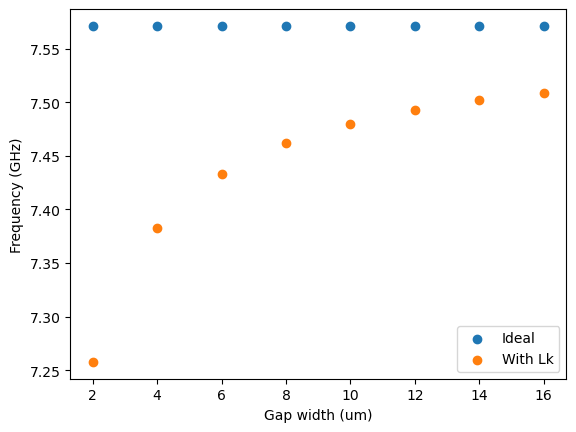

In [246]:
plt.scatter(gaps, freq_ideal, label='Ideal')
plt.scatter(gaps, freq_wLk, label='With Lk')
plt.legend()
plt.xlabel('Gap width (um)')
plt.ylabel('Frequency (GHz)')

Text(0, 0.5, 'Frequency with Lk/Frequency without Lk')

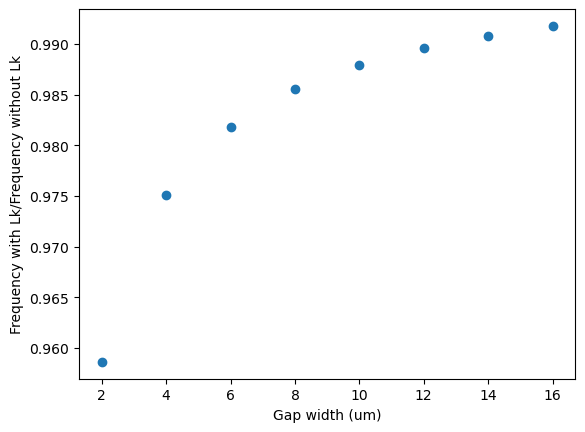

In [247]:
plt.scatter(gaps, np.array(freq_wLk )/np.array(freq_ideal), label='Ratio')
plt.xlabel('Gap width (um)')
plt.ylabel('Frequency with Lk/Frequency without Lk')

In [220]:
resonator_pin = 23.9*u.um
resonator_gap = 10*u.um

In [221]:
lk = (Lk(resonator_gap.value, resonator_pin.value, (resonator_thickness.to(u.um)).value, (lamb.to(u.um)).value)).si

In [222]:
L_tot = find_total_inductance()*u.nH/u.m + lk
L = find_total_inductance()*u.nH/u.m
C_tot = find_total_capacitance()*u.pF/u.m

In [223]:
l = (1527+1130+1035+200*np.pi)*u.um
dl = 20*u.um
f = 1/(4*l*np.sqrt(L_tot*C_tot))
df = 1/(4*l**2*np.sqrt(L_tot*C_tot))*dl
print('Frequency with inductance', f.to(u.GHz))
print('Frequency error due to length uncertainty', df.to(u.MHz))


Frequency with inductance 7.480055280396575 GHz
Frequency error due to length uncertainty 34.62733234696714 MHz


In [224]:
f0 = 1/(4*l*np.sqrt(L*C_tot))
df0 = 1/(4*l**2*np.sqrt(L*C_tot))*dl
print('Frequency without inductance', f0.to(u.GHz))
print('Frequency error due to length uncertainty', df0.to(u.MHz))


Frequency without inductance 7.5712143840733575 GHz
Frequency error due to length uncertainty 35.04933411849685 MHz


In [225]:
(f-f0).to(u.GHz)

<Quantity -0.0911591 GHz>

In [226]:
f/f0

<Quantity 0.98795978>

In [227]:
L_tot

<Quantity 391.70156397 nH / m>

In [16]:
raise Exception

Exception: 

# Optimize CPW-Feedline coupling

In [283]:
resonator_gap = '10'
resonator_pin = '23.9'
transmission_line_gap = '8'
transmission_line_pin = str(good_pins[8])
coupling_space = '10'


In [291]:
def set_up_structure(coupling_space,
                     resonator_pin = resonator_pin,
                     resonator_gap=resonator_gap,
                     transmission_line_pin=transmission_line_pin, 
                     transmission_line_gap=transmission_line_gap):
    button = driver.find_element(By.ID, 'rem-conductor')
    for i in range(10):
        button.click()
    
    button = driver.find_element(By.ID, 'add-conductor')
    button.click()
    button.click()
    time.sleep(0.5)
    conductor1 = driver.find_element(By.ID, 'tc3')
    conductor1.click()
    conductor1.click()
    time.sleep(0.5)

    input_box = driver.find_element(By.ID, 'conductor-gap-widths-elements')
    AB = input_box.find_element(By.NAME, 'AB')
    BC = input_box.find_element(By.NAME, 'BC')
    CD = input_box.find_element(By.NAME, 'CD')
    DE = input_box.find_element(By.NAME, 'DE')
    EF = input_box.find_element(By.NAME, 'EF')
    FG = input_box.find_element(By.NAME, 'FG')
    GH = input_box.find_element(By.NAME, 'GH')
    
    transmission_line_gap = str(transmission_line_gap)
    transmission_line_pin = str(transmission_line_pin)
    coupling_space = str(coupling_space)
    resonator_gap = str(resonator_gap)
    resonator_pin = str(resonator_pin)

    AB.clear()
    AB.send_keys(transmission_line_gap)

    CD.clear()
    CD.send_keys(transmission_line_gap)

    BC.clear()
    BC.send_keys(transmission_line_pin)
    time.sleep(0.5)

    
    DE.clear()
    DE.send_keys(coupling_space)

    EF.clear()
    EF.send_keys(resonator_gap)

    FG.clear()
    FG.send_keys(resonator_pin)

    GH.clear()
    GH.send_keys(resonator_gap)
    

In [285]:
def change_gap(coupling_space):
    input_box = driver.find_element(By.ID, 'conductor-gap-widths-elements')
    DE = input_box.find_element(By.NAME, 'DE')
    DE.clear()
    DE.send_keys(str(coupling_space))

In [287]:
set_up_structure(5)

In [316]:
def set_up_resonator(coupler_len = '0.17',
                     coupler_l1 = '0',
                     coupler_l2 = '0',
                     coupling_space = '10',
                     resonator_pin = resonator_pin,
                     resonator_gap = resonator_gap,):
    '''Setup quarter wave resonator'''
    ztl1 = driver.find_element(By.ID, 'Zt1_short')
    ztl1.click()
    ztl2 = driver.find_element(By.ID, 'Zt2_open')
    ztl2.click()

    SC_coupler_len = driver.find_element(By.ID, 'lc')
    SC_coupler_len.clear()
    SC_coupler_len.send_keys(coupler_len)

    SC_coupler_l1 = driver.find_element(By.ID, 'l1')
    SC_coupler_l1.clear()
    SC_coupler_l1.send_keys(coupler_l1)

    SC_coupler_l2 = driver.find_element(By.ID, 'l2')
    SC_coupler_l2.clear()
    SC_coupler_l2.send_keys(coupler_l2)
    
    input_box = driver.find_element(By.ID, 'conductor-gap-widths-elements')
    AB = input_box.find_element(By.NAME, 'AB')
    BC = input_box.find_element(By.NAME, 'BC')
    CD = input_box.find_element(By.NAME, 'CD')
    DE = input_box.find_element(By.NAME, 'DE')
    EF = input_box.find_element(By.NAME, 'EF')
    FG = input_box.find_element(By.NAME, 'FG')
    GH = input_box.find_element(By.NAME, 'GH')
    

    coupling_space = str(coupling_space)
    resonator_gap = str(resonator_gap)
    resonator_pin = str(resonator_pin)

    DE.clear()
    DE.send_keys(coupling_space)

    EF.clear()
    EF.send_keys(resonator_gap)

    FG.clear()
    FG.send_keys(resonator_pin)

    GH.clear()
    GH.send_keys(resonator_gap)

Setup CPW-feedline structure with coupling gap 5

In [304]:
i = 0

resonator_gap = pitch[i]
resonator_pin = good_pins[pitch[i]]
coupler_len = (resonator_gap*2+resonator_pin)/1000


set_up_resonator(coupler_len = str(coupler_len),
                coupling_space = '10',
                resonator_pin = resonator_pin,
                resonator_gap = resonator_gap,)

In [294]:
def find_resonator_length(freq):
    def f(length):
        time.sleep(0.01)
        SC_coupler_len = driver.find_element(By.ID, 'lc')
        SC_coupler_len.clear()
        SC_coupler_len.send_keys(length)
        return single_cpw_impedance(12.4, 9)-freq
    length_val = opt.brentq(f, 0, 10, xtol=0.001)
    return round(length_val, 2)

In [295]:
def find_resonator_specs():

    table = driver.find_element(By.ID, 'resonances')
    html = table.get_attribute('innerHTML')
    soup = BeautifulSoup(html, 'html.parser')

    # Extracting column names from HTML table headers
    cols = []
    for th in soup.find_all('th'):
        cols.append(th.text.strip())
        
    # Extracting table rows from HTML table body
    data = []
    for tr in soup.find_all('tr')[1:]:
        row = []
        for td in tr.find_all('td'):
            row.append(td.text.strip())
        data.append(row)

    # Creating pandas dataframe from table rows and columns
    df = pd.DataFrame(data, columns=cols)

    return df
    
    

In [296]:
freq = float(find_resonator_specs()['Frequency, GHz'][0])

In [311]:
def find_freq(len,l = 'l2'):
    SC_coupler_l2 = driver.find_element(By.ID, l)
    SC_coupler_l2.clear()
    SC_coupler_l2.send_keys(len)

    return float(find_resonator_specs()['Frequency, GHz'][0])

In [348]:
def f(length, l = 'l1'):
        time.sleep(0.01)
        SC_coupler_len = driver.find_element(By.ID, l)
        SC_coupler_len.clear()
        SC_coupler_len.send_keys(str(length))
        f_diff = float(find_resonator_specs()['Frequency, GHz'][0])-freq
        # print(f_diff)
        return f_diff

def find_resonator_length(freq,):
    
    length_val = opt.brentq(f, 0, 200, xtol=0.001)
    return round(length_val, 4)

    

In [349]:
i = 0
freq = freqs[i]

resonator_gap = pitch[i]
resonator_pin = good_pins[pitch[i]]
coupler_len = (resonator_gap*2+resonator_pin)/1000
coupling_space = distance_to_feedline[i]/1000


set_up_resonator(coupler_len = str(coupler_len),
                coupling_space = str(coupling_space),
                resonator_pin = resonator_pin,
                resonator_gap = resonator_gap,
                coupler_l1 = '10')

In [350]:
l = find_resonator_length(freqs[0])

In [351]:
l

5.0535

In [352]:
freq_len = {}
for freq in freqs:
    freq_len[freq] = find_resonator_length(freq)

In [353]:
freq_len

{5.9: 5.0535,
 6.2: 4.8072,
 6.5: 4.5836,
 6.7: 4.4457,
 7.0: 4.2536,
 7.2: 4.1344,
 7.5: 3.9674,
 7.9: 3.7646}

In [356]:
def find_Q(gap,freq):

    change_gap(gap)
    
    length = freq_len[freq]
    SC_coupler_len = driver.find_element(By.ID, 'l2')
    SC_coupler_len.clear()
    SC_coupler_len.send_keys(str(length))

    
    return float(find_resonator_specs()['Quality factor'][0])

    


In [357]:
freqs[0]

5.9

In [362]:
Qs = {}
for i in range(len(freqs)):
    Qs[freqs[i]] = find_Q(1,freqs[i])

In [367]:
list(Qs.values())

[1278612.0,
 1210136.0,
 1149617.0,
 1113073.0,
 1063157.0,
 1032764.0,
 990927.0,
 941290.0]

In [359]:
kappa = 2*np.pi*freq*u.GHz/Q

In [360]:
kappa.to(u.MHz)

<Quantity 0.03882113 MHz>

In [373]:
results = {}
results['Frequency'] = freqs
results['Q'] = list(Qs.values())
results['Length'] = list(freq_len.values())
results['Gap'] = pitch
results['Pin'] = [good_pins[p] for p in pitch]
results['coupling_gap'] = distance_to_feedline

In [374]:
r = pd.DataFrame(results)

In [375]:
r

,Frequency,Q,Length,Gap,Pin,coupling_gap
0,5.9,1278612.0,5.0535,10,17.73,118
1,6.2,1210136.0,4.8072,12,21.27,123
2,6.5,1149617.0,4.5836,14,24.82,158
3,6.7,1113073.0,4.4457,16,28.37,158
4,7.0,1063157.0,4.2536,2,3.55,20
5,7.2,1032764.0,4.1344,4,7.09,33
6,7.5,990927.0,3.9674,6,10.64,58
7,7.9,941290.0,3.7646,8,14.18,93


In [376]:
r.to_csv('results.csv')

Find optimal gap based on frequency

In [ ]:
def find_optimal_gap(freq):
    def kappa(gap):
        time.sleep(0.01)
        return (2*np.pi*freq*u.GHz/find_Q(gap,freq)-1*u.MHz).to(u.MHz).value
    gap_val = opt.brentq(kappa, 0, 15, xtol=0.001)
    return round(gap_val, 2)

In [ ]:
find_optimal_gap(freqs[0]/1000)

6.74

In [ ]:
gaps = {}
gapps = []

for freq in freqs/1000:
    gaps[freq] = find_optimal_gap(freq)
    gapps.append(gaps[freq])

KeyboardInterrupt: 

In [ ]:
gaps

{6.310460308: 3.9,
 6.5993999830000005: 4.58,
 6.753384976: 4.94,
 6.92724498: 5.36,
 7.175912057: 5.96,
 7.462971308: 6.68,
 7.5414966340000005: 6.87}

In [ ]:
gapps

[3.9, 4.58, 4.94, 5.36, 5.96, 6.68, 6.87, 7.45, 7.96, 8.4]

In [ ]:
raise Exception('Stop here')

In [ ]:
dat = pd.DataFrame(gaps, index = [0])
dat.to_csv('gaps_um.csv')

In [ ]:
dat.values[0]

array([3.9 , 4.58, 4.94, 5.36, 5.96, 6.68, 6.87, 7.45, 7.96, 8.4 ])

In [ ]:
data_all = pd.read_csv(r'/Users/wendy/Desktop/Wendy-qiskit-code/data/educated_guess_test2').drop(columns = ['Unnamed: 0'])

In [ ]:
data_all

,Target_qb_Freq(GHz),Ljs,Ljs (nH),Offsets (mm),TQx,TQy,Small,TQ_mir,CPW_freq_predict(GHz),Coupling_gap(um),Coupling_gap_feedline(um),Sizes (um),Buffers (um),Coupling_len(um),Coupling_len
0,4.0,13nH,13,0.000,-0.267mm,0.45mm,False,True,6.401282,15,1.11,224.327401,237.672599,69.878079,69.87807929705554um
1,4.2,13nH,13,0.000,-0.2535mm,0.44mm,False,True,6.689526,15,1.54,203.923344,231.076656,58.245181,58.24518148422307um
2,4.4,10nH,10,0.000,-0.2485mm,0.43mm,False,True,6.796263,15,1.78,235.170778,189.829222,58.658030,58.6580296993377um
3,4.6,10nH,10,0.050,0.3675mm,0.5mm,True,False,6.993693,15,2.06,213.630207,281.369793,67.261193,67.2611926131531um
4,4.8,8nH,8,0.055,0.3605mm,0.458mm,True,False,7.212317,15,2.48,238.493760,242.506240,73.386058,73.38605790089028um
5,5.0,8nH,8,0.055,0.3485mm,0.45mm,True,False,7.495441,15,3.01,218.851425,238.148575,62.802910,62.80290956338173um
6,5.2,8nH,8,0.042,0.3425mm,0.46mm,True,False,7.593559,15,3.14,200.242799,244.757201,51.557798,51.5577977048421um
7,5.4,6nH,6,0.065,0.3375mm,0.46mm,True,False,7.799704,15,3.57,236.923095,198.076905,56.360661,56.3606611629999um
8,5.6,6nH,6,0.055,0.329mm,0.44mm,True,False,8.006815,20,3.95,217.997190,200.002810,69.714398,69.71439788499663um
9,5.8,6nH,6,0.200,0.343mm,0.45mm,True,False,8.204176,20,4.28,200.537671,245.462329,71.499159,71.49915894415778um


In [ ]:
data_all['Coupling_gap_feedline(um)'] = gapps

In [ ]:
data_all['TQx'] = modified


NameError: name 'modified' is not defined

In [ ]:
data_all.to_csv(r'/Users/wendy/Desktop/Wendy-qiskit-code/data/educated_guess_test3.csv')

In [ ]:
original = data_all['TQx'].values
small = data_all['Small'].values

In [ ]:
small

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
modified = []
for i, x in enumerate(original):
    dis = 0.0125
    if small[i]:
        dis = -0.0625+0.025
    v = np.round(float(x[:-2]) + dis, decimals = 5)
    modified.append(str(v)+' mm')

In [ ]:
original

array(['-0.2545 mm', '-0.241 mm', '-0.236 mm', '0.38 mm', '0.373 mm',
       '0.361 mm', '0.355 mm', '0.35 mm', '0.3415 mm', '0.3555 mm'],
      dtype=object)

In [ ]:
modified

['-0.242 mm',
 '-0.2285 mm',
 '-0.2235 mm',
 '0.3425 mm',
 '0.3355 mm',
 '0.3235 mm',
 '0.3175 mm',
 '0.3125 mm',
 '0.304 mm',
 '0.318 mm']

In [ ]:
conductor1 = driver.find_element(By.ID, 'tc3')

In [ ]:
conductor1.click()

In [ ]:
conductor1.click()

In [ ]:
input_box = driver.find_element(By.ID, 'conductor-gap-widths-elements')
AB = input_box.find_element(By.NAME, 'AB')
BC = input_box.find_element(By.NAME, 'BC')
CD = input_box.find_element(By.NAME, 'CD')
DE = input_box.find_element(By.NAME, 'DE')
EF = input_box.find_element(By.NAME, 'EF')
FG = input_box.find_element(By.NAME, 'FG')
GH = input_box.find_element(By.NAME, 'GH')

In [ ]:
AB.clear()
AB.send_keys('9')
CD.clear()
CD.send_keys('9')

BC.clear()
BC.send_keys('15.95')

DE.clear()
DE.send_keys('5')

EF.clear()
EF.send_keys('7.4')

FG.clear()
FG.send_keys('12.5')

GH.clear()
GH.send_keys('7.4')



In [ ]:
epsi = driver.find_element(By.ID, 'epsilon')
epsi.clear()
epsi.send_keys('11.45')

In [ ]:
SC_coupler_len = driver.find_element(By.ID, 'lc')
SC_coupler_len.clear()
SC_coupler_len.send_keys('0.12')

SC_coupler_l1 = driver.find_element(By.ID, 'l1')
SC_coupler_l1.clear()
SC_coupler_l1.send_keys('0')

SC_coupler_l2 = driver.find_element(By.ID, 'l2')
SC_coupler_l2.clear()
SC_coupler_l2.send_keys('4')



In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

soup = BeautifulSoup(html, 'html.parser')

# Extracting column names from HTML table headers
cols = []
for th in soup.find_all('th'):
    cols.append(th.text.strip())
    
# Extracting table rows from HTML table body
data = []
for tr in soup.find_all('tr')[1:]:
    row = []
    for td in tr.find_all('td'):
        row.append(td.text.strip())
    data.append(row)

# Creating pandas dataframe from table rows and columns
df = pd.DataFrame(data, columns=cols)

print(df)